In [1]:
import sklearn.metrics as skm
import sys
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

ssl_features_train = np.load("./old_but_full_features/self_supervised_cifar100/features_train2.npy")
ssl_labels_train = np.load("./old_but_full_features/self_supervised_cifar100/labels_train2.npy")
ssl_features_test = np.load("./old_but_full_features/self_supervised_cifar100/features_test2.npy")
ssl_features_ood = np.load("./old_but_full_features/self_supervised_cifar100/features_ood2.npy")


sp_features_train = np.load("./old_but_full_features/supervised_cifar100/features_train2.npy")
sp_labels_train = np.load("./old_but_full_features/supervised_cifar100/labels_train2.npy")
sp_features_test = np.load("./old_but_full_features/supervised_cifar100/features_test2.npy")
sp_features_ood = np.load("./old_but_full_features/supervised_cifar100/features_ood2.npy")


In [2]:
# -- calculate SL and SSL score separately


import sklearn.metrics as skm
import sys
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def get_roc_sklearn(xin, xood):
    labels = [0] * len(xin) + [1] * len(xood)
    data = np.concatenate((xin, xood))
    auroc = skm.roc_auc_score(labels, data)
    return auroc


def get_scores_multi_cluster(ftrain, ftest, food, ypred):
    print("using multiple clusters")
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]
    

    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
#     print("din shape is looking like:", din)
    din_index = np.argmin(din, axis = 0)
    
    din = np.min(din, axis=0)
    
    dood_index = np.argmin(dood, axis = 0)
    dood = np.min(dood, axis=0)

    return din, dood, din_index, dood_index

def get_scores(ftrain, ftest, food, labelstrain, cluster):

    # standardize data
    print("ftrain size is:", ftrain.shape)
    ftrain /= np.linalg.norm(ftrain, axis=-1, keepdims=True) + 1e-10
    ftest /= np.linalg.norm(ftest, axis=-1, keepdims=True) + 1e-10
    food /= np.linalg.norm(food, axis=-1, keepdims=True) + 1e-10

    m, s = np.mean(ftrain, axis=0, keepdims=True), np.std(ftrain, axis=0, keepdims=True)

    ftrain = (ftrain - m) / (s + 1e-10)
    ftest = (ftest - m) / (s + 1e-10)
    food = (food - m) / (s + 1e-10)
    
    return get_scores_multi_cluster(ftrain, ftest, food, labelstrain)   # for supervised learning

def get_eval_results(dtest, dood):
    """
    None.
    """

    auroc = get_roc_sklearn(dtest, dood)
    return auroc

In [3]:
#calculate score of id test samples and ood test samples

# Get features --> individual cluster (self-sp and sp) --> calcualte score

ssl_din, ssl_dout, ssl_idxin, ssl_idxood = get_scores(ssl_features_train, ssl_features_test, ssl_features_ood, ssl_labels_train, cluster = 10)

sp_din, sp_dout, sp_idxin, sp_idxood = get_scores(sp_features_train, sp_features_test, sp_features_ood, sp_labels_train, cluster = 10)


ftrain size is: (50000, 2048)
using multiple clusters
ftrain size is: (50000, 2048)
using multiple clusters


In [4]:
auroc = get_eval_results(ssl_din, ssl_dout)

print("AUROC is:", auroc)

auroc = get_eval_results(sp_din, sp_dout)

print("AUROC is:", auroc)


AUROC is: 0.8805713449999999
AUROC is: 0.8796951750000002


In [5]:
np.save("./old_but_full_features/self_supervised_cifar100/ssl_test_score.npy",ssl_din)
np.save("./old_but_full_features/self_supervised_cifar100/ssl_ood_score.npy",ssl_dout)
np.save("./old_but_full_features/supervised_cifar100/sl_test_score.npy",sp_din)
np.save("./old_but_full_features/supervised_cifar100/sl_ood_score.npy",sp_dout)
np.save("./old_but_full_features/supervised_cifar100/sl_ood_minlabels.npy",sp_idxood)
np.save("./old_but_full_features/supervised_cifar100/sl_test_minlabels.npy",sp_idxin)
np.save("./old_but_full_features/self_supervised_cifar100/ssl_ood_minlabels.npy",ssl_idxood)
np.save("./old_but_full_features/self_supervised_cifar100/ssl_test_minlabels.npy",ssl_idxin)



In [6]:
# np.save("./old_but_full_features/self_supervised_cifar100/ssl_test_score.npy",ssl_din)
# np.save("./old_but_full_features/self_supervised_cifar100/ssl_ood_score.npy",ssl_dout)
# np.save("./old_but_full_features/supervised_cifar100/sl_test_score.npy",sp_din)
# np.save("./old_but_full_features/supervised_cifar100/sl_ood_score.npy",sp_dout)


In [7]:
# calculate score for combined feature


import matplotlib.pyplot as plt

def dnorm(ftrain, ftest, food):
    
    print("ftrain size is:", ftrain.shape)
    ftrain /= np.linalg.norm(ftrain, axis=-1, keepdims=True) + 1e-10
    ftest /= np.linalg.norm(ftest, axis=-1, keepdims=True) + 1e-10
    food /= np.linalg.norm(food, axis=-1, keepdims=True) + 1e-10

    m, s = np.mean(ftrain, axis=0, keepdims=True), np.std(ftrain, axis=0, keepdims=True)
    print("mean value is:", np.mean(m))
    print("std value is:", np.mean(s))
#     m2, s2 = np.mean(ftest, axis=0, keepdims=True), np.std(ftest, axis=0, keepdims=True)
#     m3, s3 = np.mean(food, axis=0, keepdims=True), np.std(food, axis=0, keepdims=True)

    ftrain = (ftrain - m) / (s + 1e-10)
    ftest = (ftest - m) / (s + 1e-10)
    food = (food - m) / (s + 1e-10)
#     print("ftrain shape is:", ftrain.shape)
#     ftrain = (ftrain - m) / (s + 1e-10)
#     ftest = (ftrain - m2) / (s2 + 1e-10)
#     food = (ftrain - m3) / (s3 + 1e-10)

#     plt.figure(0).clf()
#     plt.plot(food[960])
#     plt.hist(ftrain[60], density=True, bins=100)
#     plt.show()
    
    
    return ftrain, ftest, food

ssl_features_train,  ssl_features_test, ssl_features_ood= dnorm(ssl_features_train, ssl_features_test, ssl_features_ood)
sp_features_train,  sp_features_test, sp_features_ood= dnorm(sp_features_train, sp_features_test, sp_features_ood)


fl_features_train = 0.1 * ssl_features_train + 0.9 * sp_features_train
fl_features_test = 0.1 * ssl_features_test + 0.9 * sp_features_test
fl_features_ood = 0.1 * ssl_features_ood + 0.9 * sp_features_ood
print("new fl_feature_train size is:", fl_features_train.shape)

fl_din, fl_dout, fl_idxin, fl_idxood = get_scores_multi_cluster(fl_features_train, fl_features_test, fl_features_ood, ssl_labels_train)

ftrain size is: (50000, 2048)
mean value is: 1.2514749e-06
std value is: 0.022090783
ftrain size is: (50000, 2048)
mean value is: -0.00021042174
std value is: 0.02207962
new fl_feature_train size is: (50000, 2048)
using multiple clusters


In [8]:
auroc = get_eval_results(fl_din, fl_dout)

print("AUROC is:", auroc)


AUROC is: 0.9135138050000001


In [10]:
np.save("./old_but_full_features/ensemble_cifar100/fl_test_score.npy",fl_din)
np.save("./old_but_full_features/ensemble_cifar100/fl_ood_score.npy",fl_dout)
np.save("./old_but_full_features/ensemble_cifar100/fl_ood_minlabels.npy",fl_idxood)
np.save("./old_but_full_features/ensemble_cifar100/fl_test_minlabels.npy",fl_idxin)

In [11]:
print(sp_dout)
print(sp_din)

[ 6759.75252719 11261.13142373  8778.70741014 ... 10547.83388989
  9703.84838071 14297.67649249]
[3554.01341274 2803.23943896 4732.86509977 ... 2920.56238729 4034.69434518
 2608.63471948]


In [ ]:
f_change= fl_dout - sp_dout
indices = (-f_change).argsort()[:10]
print(indices)

In [ ]:
plt.figure(0).clf()
plt.plot(sp_features_ood[645])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

idx = 5633
plt.figure(0).clf()
plt.plot(ssl_features_ood[idx])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()
print((-ssl_features_ood[idx]).argsort()[:10])

In [12]:
## calculate fpr, tpr, Threshold 

labels = [0] * len(fl_din) + [1] * len(fl_dout)
print("length of labels is:", len(labels))
data = np.concatenate((fl_din, fl_dout))
fpr, tpr, thresh = roc_curve(labels, data)
thresh.size

length of labels is: 20000


4534

In [25]:
## select threshold that fpr approximates to 0.23
Th = thresh[3900]
print(Th)
index = np.where(sp_din > Th)[0]
print(index.size)

4927.24158062202
2349


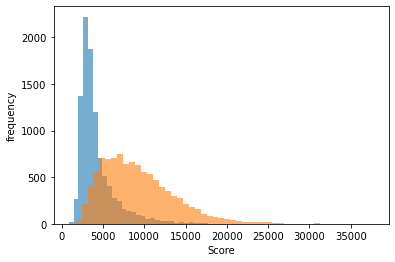

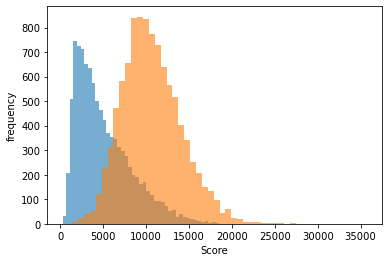

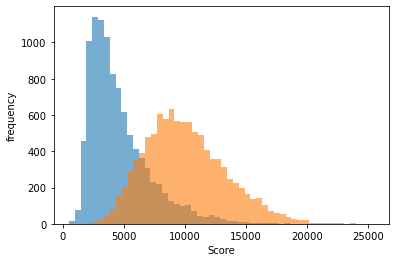

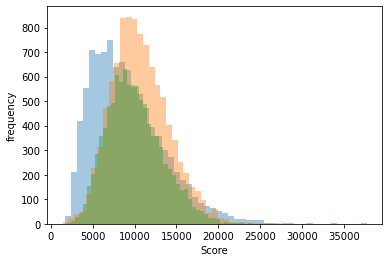

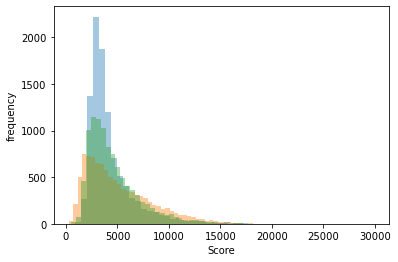

10000
10000


In [126]:
# score distritbuion of sl and ssl and ensemble
plt.hist(sp_din, alpha=.6, bins=50)  # density=False would make counts
plt.hist(sp_dout, alpha=.6, bins=50)  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()

plt.hist(ssl_din, alpha=.6, bins=50)  # density=False would make counts
plt.hist(ssl_dout, alpha=.6, bins=50)  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()

plt.hist(fl_din, alpha=.6, bins=50)  # density=False would make counts
plt.hist(fl_dout, alpha=.6, bins=50)  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()


# plt.hist(ssl_dout, alpha=.6, bins=50)  # density=False would make counts
# plt.hist(fl_dout, alpha=.6, bins=50)  # density=False would make counts
# plt.ylabel('frequency')
# plt.xlabel('Score');
# plt.show()



# plt.hist(ssl_din, alpha=.6, bins=50)  # density=False would make counts
# plt.hist(fl_din, alpha=.6, bins=50)  # density=False would make counts
# plt.ylabel('frequency')
# plt.xlabel('Score');
# plt.show()




plt.hist(sp_dout, alpha=.4, bins=50)  # density=False would make counts
plt.hist(ssl_dout, alpha=.4, bins=50)
plt.hist(fl_dout, alpha=.4, bins=50)# density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()



# plt.hist(sp_din, alpha=.6, bins=50)  # density=False would make counts
# plt.hist(fl_din, alpha=.6, bins=50)  # density=False would make counts
# plt.ylabel('frequency')
# plt.xlabel('Score');
# plt.show()



plt.hist(sp_din, alpha=.4, bins=50)  # density=False would make counts
plt.hist(ssl_din, alpha=.4, bins=50)
plt.hist(fl_din, alpha=.4, bins=50) # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()


print(ssl_dout.size)
print(fl_dout.size)

In [54]:
# find a identical precision rate (TP/(TP+FP))
# find a identical fpr 
Th2 = thresh[3200]
print(Th2)
sp_fpr_idx = np.where(sp_din > Th)[0]
fl_fpr_idx = np.where(fl_din > Th2)[0]
print(sp_fpr_idx.size)
print(fl_fpr_idx.size)


sp_fnr_idx = np.where(sp_dout < Th)[0]
fl_fnr_idx = np.where(fl_dout < Th2)[0]
print(sp_fnr_idx.size)
print(fl_fnr_idx.size)
print(sp_fnr_idx[:150])
print(fl_fnr_idx[:150])

5900.374935925428
2349
2353
1551
877
[  6  11  12  15  17  36  39  40  42  50  58  61  65  66  70  71  73  77
  80  83  89  94  97  98 105 120 134 137 144 145 146 156 164 167 172 185
 188 193 197 206 208 215 217 234 238 243 255 256 257 277 278 279 280 286
 292 295 298 302 305 313 314 321 324 333 351 353 374 380 383 396 404 410
 416 421 426 432 438 446 456 458 459 460 463 470 472 494 497 502 509 511
 512 516 517 542 545 547 551 556 559 560 587 590 597 608 616 619 625 632
 635 660 663 687 704 705 706 716 719 720 728 731 732 736 739 750 754 764
 766 772 777 778 780 788 796 803 804 805 808 809 810 816 817 829 842 861
 868 875 883 885 887 889]
[  12   13   15   17   42   56   58   65   66   94  156  164  193  215
  234  243  254  277  278  280  292  298  313  331  353  383  396  404
  416  432  438  446  456  458  472  512  517  542  560  577  608  616
  619  622  625  632  663  687  704  705  706  720  736  739  750  766
  803  804  805  809  810  817  842  846  858  861  883  890  895  90

In [49]:
ood_labels = np.load("./supervised_cifar100/labels_ood.npy")

In [112]:
f_change= fl_dout - sp_dout
indices = (-f_change).argsort()[:10]
print(indices)

[ 645  539 3735  341 2155 4977 8243 1912 5668 4909]


In [55]:
## find sample index that change from TP to FN. 
idx_fn_to_tp1 = np.setdiff1d(fl_fnr_idx, sp_fnr_idx)
print(idx_fn_to_tp1.size)

191


865
[   6   11   36   39   40   50   61   70   71   73   77   80   83   89
   97   98  105  120  134  137  144  145  146  167  172  185  188  197
  206  208  217  238  255  256  257  279  286  295  302  305  314  321
  324  333  351  374  380  410  421  426  459  460  463  470  494  497
  502  509  511  516  545  547  551  556  559  587  590  597  635  660
  716  719  728  731  732  754  764  772  777  778  780  788  796  808
  816  829  868  875  885  887  889  897  898  933  946  953  971  972
  977  987  990 1033 1034 1035 1047 1049 1084 1099 1140 1145 1149 1189
 1205 1224 1235 1241 1242 1260 1275 1279 1280 1299 1326 1328 1349 1387
 1413 1418 1445 1450 1455 1456 1467 1472 1488 1513 1547 1553 1562 1576
 1580 1611 1639 1659 1663 1664 1673 1692 1726 1736 1753 1768 1769 1780
 1787 1791 1811 1828 1858 1883 1886 1897 1912 1923 1927 1950 1986 1994
 2008 2012 2016 2029 2040 2053 2060 2079 2085 2091 2096 2110 2112 2128
 2136 2138 2178 2188 2199 2220 2227 2253 2266 2305 2316 2322 2333 2342
 2

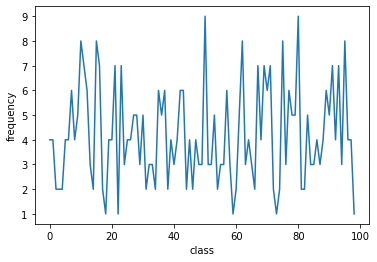

[8 6 5 8 4]
[0 4 3 9 3]
(array([  1,  60,  66,  78, 103, 206, 225, 254, 381]),)


In [99]:
## get sample index that change from FN to TP
## get the corresponding label and closest cluster

idx_fn_to_tp = np.setdiff1d(sp_fnr_idx, fl_fnr_idx)
print(idx_fn_to_tp.size)
print(idx_fn_to_tp[:415])
# print(ood_labels[fn_to_tp[:415]])
label_fn_to_tp = ood_labels[idx_fn_to_tp[:415]]
print(label_fn_to_tp)
unique, counts = np.unique(label_fn_to_tp, return_counts=True)
print(np.asarray((unique, counts)).T)
# print(counts)
plt.plot(counts)
plt.ylabel('frequency')
plt.xlabel('class');
plt.show()


##  cluster 
sl_cluster_fn_to_tp = sp_idxood[idx_fn_to_tp]
fl_cluster_fn_to_tp = fl_idxood[idx_fn_to_tp]
# print(sl_cluster_fn_to_tp)
# print(fl_cluster_fn_to_tp)
d_index = np.where(sl_cluster_fn_to_tp != fl_cluster_fn_to_tp)
# print(d_index)
print(sl_cluster_fn_to_tp[d_index])
print(fl_cluster_fn_to_tp[d_index])

print(np.where(label_fn_to_tp == 81))

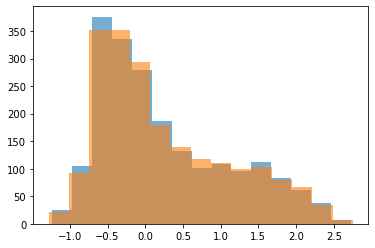

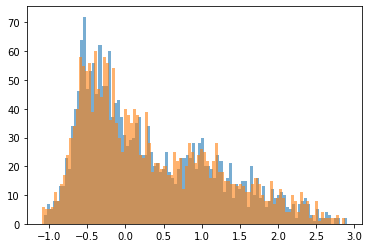

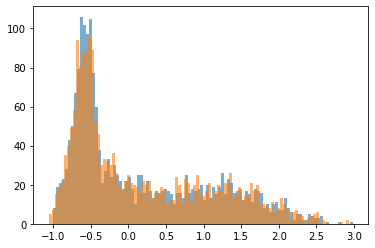

In [115]:
## visualize one fn -> tp sample feature


plt.figure(0).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[50], alpha=.6, bins=100)
plt.hist(fl_features_ood[60], alpha=.6, bins=100)
plt.show()

plt.figure(1).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[6], alpha=.6, bins=100)
plt.hist(fl_features_ood[6], alpha=.6, bins=100)
plt.show()

plt.figure(2).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[11], alpha=.6, bins=100)
plt.hist(fl_features_ood[11], alpha=.6, bins=100)
plt.show()
# plt.figure(1).clf()
# # plt.plot(0.1 * ssl_features_ood[50])
# plt.hist(0.1 * ssl_features_ood[50], bins=100)
# plt.show()


# plt.figure(2).clf()
# # plt.plot(0.1 * fl_features_ood[50])
# plt.hist(fl_features_ood[60], bins=100)
# plt.show()

2743


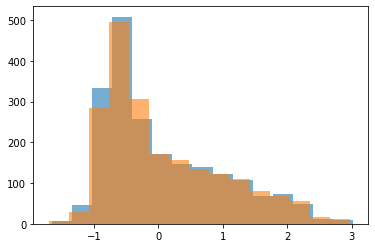

In [111]:
ix = idx_fn_to_tp[225]
print(ix)

# plt.figure(0).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[ix], alpha=.6, bins=15)
plt.hist(fl_features_ood[ix], alpha=.6, bins=15)
plt.show()

In [ ]:
# ## get false negative index and number
# index2 = np.where(sp_dout < Th)[0]
# # print(index[:150])
# print(index2.size)
# # print(ood_labels[:150])

In [33]:
# ## get false negative index and number
# index2 = np.where(sp_dout < Th)[0]
# # print(index[:150])
# print(index2.size)
# # print(ood_labels[:150])

1551


In [34]:
# index1 = np.where(fl_dout < Th)[0]
# # print(index1)
# index1.size

348

length of labels is: 20000
size of threshold is : [37734.50014502 37733.50014502 30545.55789859 ...  1689.0294869
  1687.31400305   875.61908116]
size of fpr is : [0.     0.     0.     ... 0.9955 0.9955 1.    ]
size of tpr is : [0.000e+00 1.000e-04 1.200e-03 ... 9.999e-01 1.000e+00 1.000e+00]


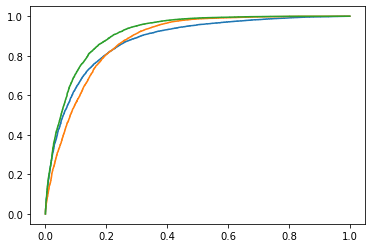

In [15]:
def get_roc_sklearn_plot1(xin1, xood1, xin2, xood2, xin3, xood3):
    
    labels1 = [0] * len(xin1) + [1] * len(xood1)
    print("length of labels is:", len(labels1))
    data1 = np.concatenate((xin1, xood1))
    labels2 = [0] * len(xin2) + [1] * len(xood2)
    data2 = np.concatenate((xin2, xood2))
    labels3 = [0] * len(xin3) + [1] * len(xood3)
    data3 = np.concatenate((xin3, xood3))
    
    plt.figure(0).clf()
    fpr, tpr, thresh = roc_curve(labels1, data1)
    print("size of threshold is :", thresh)
    plt.plot(fpr,tpr,label="SL")
    print("size of fpr is :", fpr)
    print("size of tpr is :", tpr)
    
    fpr, tpr, thresh = roc_curve(labels2, data2)
    plt.plot(fpr,tpr,label="SSL")
    
    
    fpr, tpr, thresh = roc_curve(labels3, data3)
    plt.plot(fpr,tpr,label="Ensemble")
    
get_roc_sklearn_plot1(sp_din, sp_dout, ssl_din, ssl_dout, fl_din, fl_dout)

In [ ]:
# fn_to_tp = np.setdiff1d(index, index1)
# print(fn_to_tp[:150])
# print(ood_labels[fn_to_tp[:150]])
# print(ood_labels[50])

In [ ]:
## visualize one fn -> tp sample feature

plt.figure(0).clf()
plt.plot(0.9 * sp_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(1).clf()
plt.plot(0.1 * ssl_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


plt.figure(1).clf()
plt.plot(0.1 * fl_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


In [ ]:
## visualize one fn -> tp sample feature

plt.figure(0).clf()
plt.plot(0.9 * sp_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(1).clf()
plt.plot(0.1 * ssl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


plt.figure(1).clf()
plt.plot(0.1 * fl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

In [ ]:
## find the largest values in ssl feature

ssl_idx = (-ssl_features_ood[6]).argsort()[:10]
ssl_idx

In [ ]:
sp_features_ood[6][986]

In [ ]:
ssl_idx = (-ssl_features_ood[17]).argsort()[:10]
ssl_idx

In [ ]:
a = [1, 2, 3]
b = [1]